In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#model
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

    def forward(self, inputs):
        flat_input = inputs.view(-1, self.embedding_dim)
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) +
                     torch.sum(self.embedding.weight**2, dim=1) -
                     2 * torch.matmul(flat_input, self.embedding.weight.t()))
        
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.size(0), self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        quantized = torch.matmul(encodings, self.embedding.weight).view(inputs.shape)
        e_latent_loss = torch.mean((quantized.detach() - inputs) ** 2)
        q_latent_loss = torch.mean((quantized - inputs.detach()) ** 2)
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        return quantized, loss, encoding_indices

class Encoder(nn.Module):
    def __init__(self, in_channels, embedding_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, embedding_dim, 1)
        )

    def forward(self, x):
        return self.conv(x)

class Decoder(nn.Module):
    def __init__(self, embedding_dim, out_channels):
        super(Decoder, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(embedding_dim, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, 1)
        )

    def forward(self, x):
        return self.deconv(x)

class VQVAE(nn.Module):
    def __init__(self, in_channels, embedding_dim, num_embeddings, commitment_cost):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(in_channels, embedding_dim)
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(embedding_dim, in_channels)

    def forward(self, x):
        z = self.encoder(x)
        quantized, vq_loss, _ = self.vq(z)
        x_recon = self.decoder(quantized)
        return x_recon, vq_loss

In [5]:

transform = transforms.Compose([
    transforms.Resize((96, 256)),
    transforms.ToTensor()
])

# Loading my dataset
dataset = datasets.ImageFolder("/kaggle/input/cityscapes/train", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
#training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VQVAE(in_channels=3, embedding_dim=64, num_embeddings=512, commitment_cost=0.25).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        images = images.to(device)
        recon, vq_loss = model(images)
        recon_loss = nn.functional.mse_loss(recon, images)
        loss = recon_loss + vq_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.0846
Epoch 2, Loss: 0.0525
Epoch 3, Loss: 0.0611
Epoch 4, Loss: 0.0951
Epoch 5, Loss: 0.1348
Epoch 6, Loss: 0.1064
Epoch 7, Loss: 0.0992
Epoch 8, Loss: 0.0974
Epoch 9, Loss: 0.0887
Epoch 10, Loss: 0.0922
Epoch 11, Loss: 0.0933
Epoch 12, Loss: 0.0939
Epoch 13, Loss: 0.0879
Epoch 14, Loss: 0.0847
Epoch 15, Loss: 0.0864
Epoch 16, Loss: 0.0880
Epoch 17, Loss: 0.0852
Epoch 18, Loss: 0.0839
Epoch 19, Loss: 0.0867
Epoch 20, Loss: 0.0716


In [18]:
model.eval()
test_image, _ = dataset[0]
test_image = test_image.unsqueeze(0).to(device)


def crop_left(image):
    return image[:, :, :, :128]
    
cropped_image = crop_left(test_image)
with torch.no_grad():
    outpainted, _ = model(cropped_image)

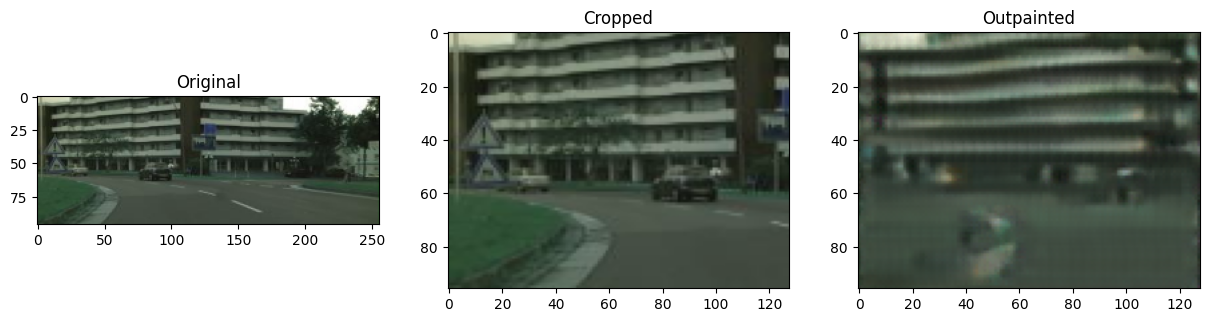

In [15]:

def visualize_results(original, cropped, outpainted):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(original.permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Original")
    axs[1].imshow(cropped.permute(1, 2, 0).cpu().numpy())
    axs[1].set_title("Cropped")
    axs[2].imshow(outpainted.permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("Outpainted")
    plt.show()

visualize_results(test_image[0], cropped_image[0], outpainted[0])


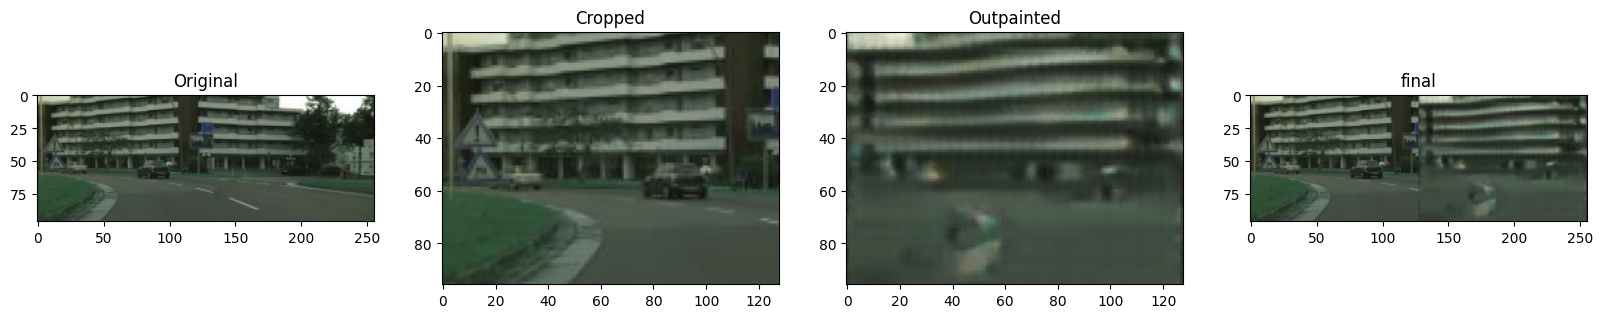

In [17]:
def visualize_results(original, cropped, outpainted):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))  
    
  
    original = original.squeeze(0)
    cropped = cropped.squeeze(0)
    outpainted = outpainted.squeeze(0)
    
    #original image
    axs[0].imshow(original.permute(1, 2, 0).cpu().numpy())
    axs[0].set_title("Original")
    
    # Cropped Image
    axs[1].imshow(cropped.permute(1, 2, 0).cpu().numpy())
    axs[1].set_title("Cropped")
    
    # Outpainted Image
    axs[2].imshow(outpainted.permute(1, 2, 0).cpu().numpy())
    axs[2].set_title("Outpainted")
    
    # final
    stitched_image = torch.cat([cropped, outpainted], dim=2) 
    axs[3].imshow(stitched_image.permute(1, 2, 0).cpu().numpy())
    axs[3].set_title("final")

    plt.show()


visualize_results(test_image, cropped_image, outpainted)

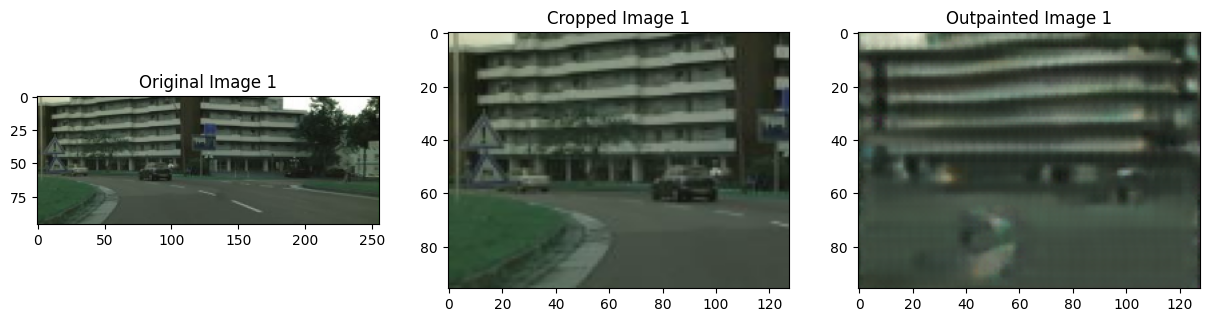

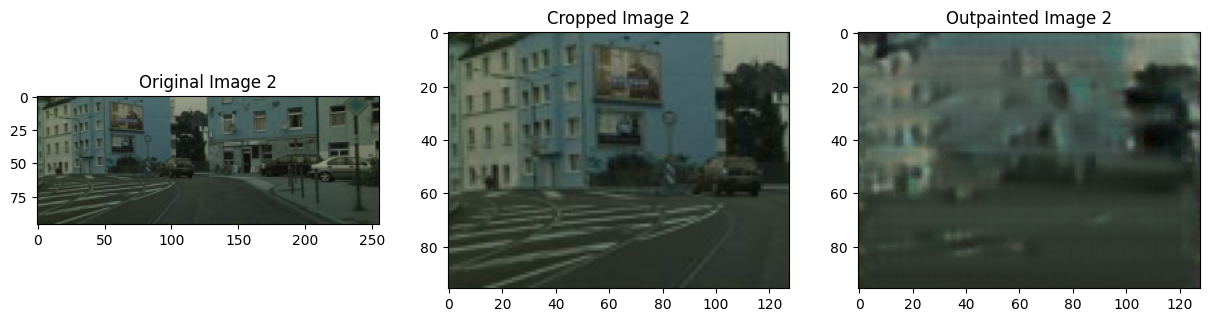

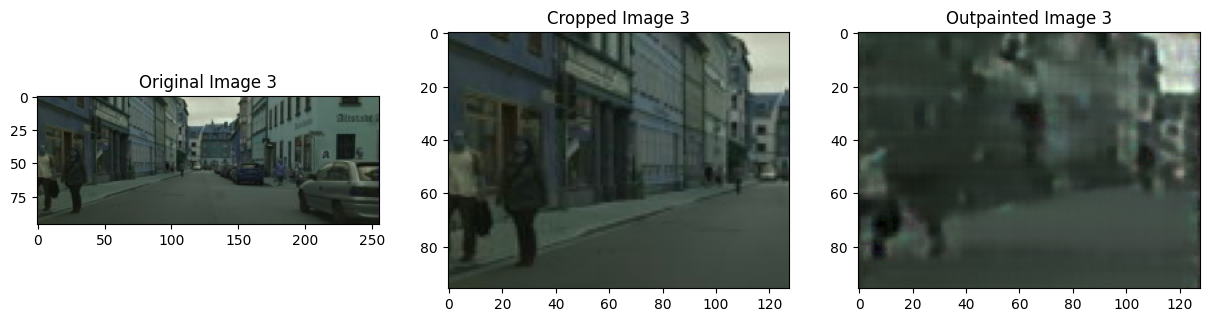

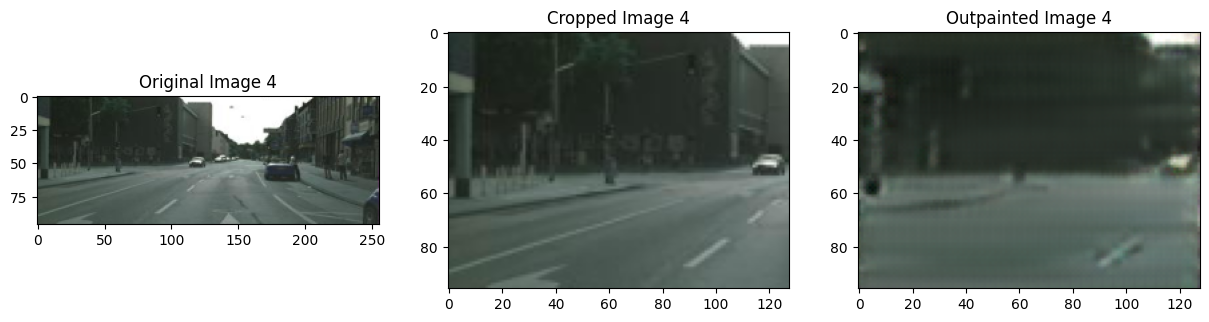

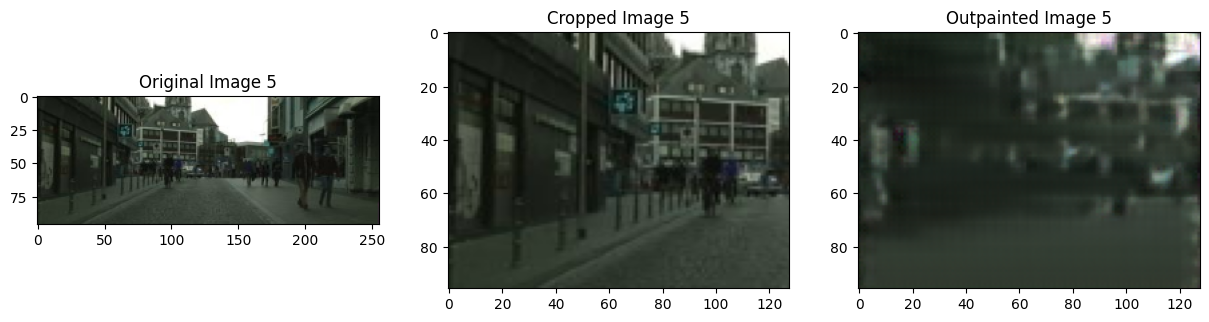

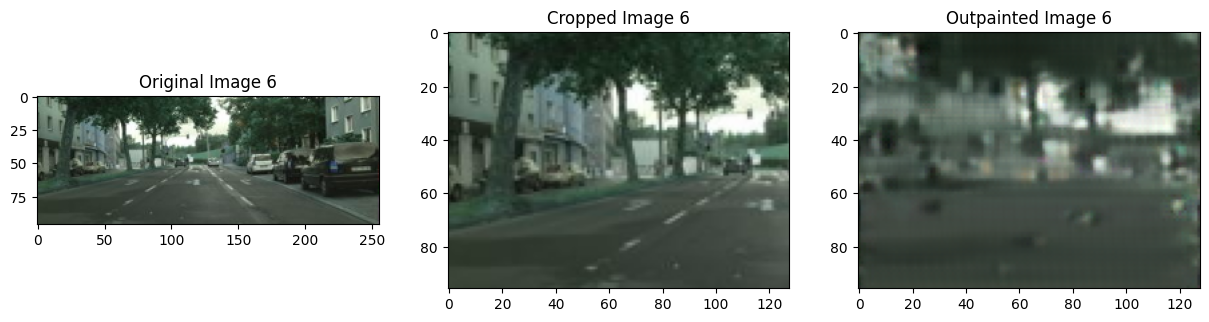

In [21]:
def visualize_results(original, cropped, outpainted, index):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
  
    axs[0].imshow(original.squeeze(0).permute(1, 2, 0).cpu().numpy())
    axs[0].set_title(f"Original Image {index}")
    
    axs[1].imshow(cropped.squeeze(0).permute(1, 2, 0).cpu().numpy())
    axs[1].set_title(f"Cropped Image {index}")
    
    axs[2].imshow(outpainted.squeeze(0).permute(1, 2, 0).cpu().numpy())
    axs[2].set_title(f"Outpainted Image {index}")
    
    plt.show()


for index in range(6): 
    test_image, _ = dataset[index]
    test_image = test_image.unsqueeze(0).to(device) 
    
    cropped_image = crop_left(test_image)
    
    with torch.no_grad():
        outpainted, _ = model(cropped_image)

   
    visualize_results(test_image, cropped_image, outpainted, index + 1)  
